# Clustering Consulting Project

A large technology firm needs your help, they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* 'Session_Connection_Time': How long the session lasted in minutes
* 'Bytes Transferred': Number of MB transferred during session
* 'Kali_Trace_Used': Indicates if the hacker was using Kali Linux
* 'Servers_Corrupted': Number of server corrupted during the attack
* 'Pages_Corrupted': Number of pages illegally accessed
* 'Location': Location attack came from (Probably useless because the hackers used VPNs)
* 'WPM_Typing_Speed': Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. Their certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? It's probably not possible to know for sure, but maybe what you've just learned about Clustering can help!

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

In [ ]:
from google.colab import drive    #To get the authorization code by loggin into your Google account.
drive.mount("/content/Mydrive")

Mounted at /content/Mydrive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz


In [ ]:
!pip install -q findspark

In [ ]:

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content//spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("Customer Use Case").setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
conf

In [ ]:
sc

<SparkContext master=local appName=Customer Use Case>

In [ ]:
spark

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
# from pyspark.sql.functions import isnan, when, count, col, countDistinct

In [ ]:
dataschema = StructType([
             StructField("Session_Connection_Time",DoubleType(),True),
             StructField("Bytes_Transferred",DoubleType(),True),
             StructField("Kali_Trace_Used",StringType(),True),
             StructField("Servers_Corrupted",DoubleType(),True),
             StructField("Pages_Corrupted",DoubleType(),True),
             StructField("Location",StringType(),True),
             StructField("WPM_Typing_speed",DoubleType(),True),

])

In [ ]:
hackdf = spark.read.format('csv').option('header','true').option('inferSchema','true').load("/content/hack_data.csv", schema=dataschema)

In [ ]:
import pyspark.sql.functions as func
hackdf = hackdf.withColumn("Servers_Corrupted",func.round(hackdf["Servers_Corrupted"]).cast("integer"))

In [ ]:

hackdf.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes_Transferred: double (nullable = true)
 |-- Kali_Trace_Used: string (nullable = true)
 |-- Servers_Corrupted: integer (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_speed: double (nullable = true)



In [ ]:
hackdf.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes_Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|                3|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|                3|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|                4|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|                2|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|                4

In [ ]:
hackdf = hackdf.drop("Location")

In [ ]:
hackdf.describe().select("summary","Session_Connection_Time","Bytes_Transferred","Servers_Corrupted","Pages_Corrupted","WPM_Typing_speed").show()

+-------+-----------------------+------------------+-----------------+------------------+------------------+
|summary|Session_Connection_Time| Bytes_Transferred|Servers_Corrupted|   Pages_Corrupted|  WPM_Typing_speed|
+-------+-----------------------+------------------+-----------------+------------------+------------------+
|  count|                    334|               334|              334|               334|               334|
|   mean|     30.008982035928145| 607.2452694610777|5.278443113772455|10.838323353293413|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|2.325666161415226|  3.06352633036022| 13.41106336843464|
|    min|                    1.0|              10.0|                1|               6.0|              40.0|
|    max|                   60.0|            1330.5|               10|              15.0|              75.0|
+-------+-----------------------+------------------+-----------------+------------------+------------------+



In [ ]:
data_df = hackdf.na.drop(how="any")

In [ ]:
data_df.count()

334

In [ ]:
hackdf.count()

334

In [ ]:
hackdf.dtypes

[('Session_Connection_Time', 'double'),
 ('Bytes_Transferred', 'double'),
 ('Kali_Trace_Used', 'string'),
 ('Servers_Corrupted', 'int'),
 ('Pages_Corrupted', 'double'),
 ('WPM_Typing_speed', 'double')]

In [ ]:
cat_cols =["Kali_Trace_Used"]
num_cols=["Session_Connection_Time","Bytes_Transferred","Servers_Corrupted","Pages_Corrupted","WPM_Typing_speed"]

In [ ]:
(train_df,test_df) =hackdf.randomSplit([0.7,0.3])

In [ ]:
train_df.count()

229

In [ ]:

test_df.count()

105

In [ ]:
from pyspark.ml.feature import VectorAssembler
vector_assembler_numVars = VectorAssembler(inputCols=num_cols , outputCol="num_features_all")

In [ ]:
from pyspark.ml.feature import MinMaxScaler
minMax_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all",outputCol="scaled_num_features")

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
indexers_Cat = [StringIndexer(inputCol=cat_var_name,outputCol="{0}_index".format(cat_cols))
                for cat_var_name in cat_cols]

encoders_Cat = [OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_vec".format(indexer.getInputCol())) for indexer in indexers_Cat]

assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders_Cat],outputCol="cat_features")
assembler = VectorAssembler(inputCols=["scaled_num_features","cat_features"],outputCol="features")

In [ ]:
preprocessingStages = [vector_assembler_numVars] + [minMax_Scalar_NumVars] + indexers_Cat + encoders_Cat + [assembler_Cat] + [assembler]

In [ ]:
preprocessingStages

[VectorAssembler_2447a0f9a75f,
 MinMaxScaler_0fea9b06ec33,
 StringIndexer_e813364fc5e7,
 OneHotEncoder_ad6835306cf9,
 VectorAssembler_8adaf482e931,
 VectorAssembler_da42360ece43]

In [ ]:
df=hackdf.toPandas()

In [ ]:
df

,Session_Connection_Time,Bytes_Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_speed
0,8.0,391.09,1,3,7.0,72.37
1,20.0,720.99,0,3,9.0,69.08
2,31.0,356.32,1,4,8.0,70.58
3,2.0,228.08,1,2,8.0,70.80
4,20.0,408.50,0,4,8.0,71.28
...,...,...,...,...,...,...
329,39.0,761.91,1,7,14.0,43.23
330,43.0,983.48,0,9,13.0,43.21
331,39.0,690.22,1,7,13.0,42.75
332,36.0,1060.69,1,6,14.0,43.86


In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

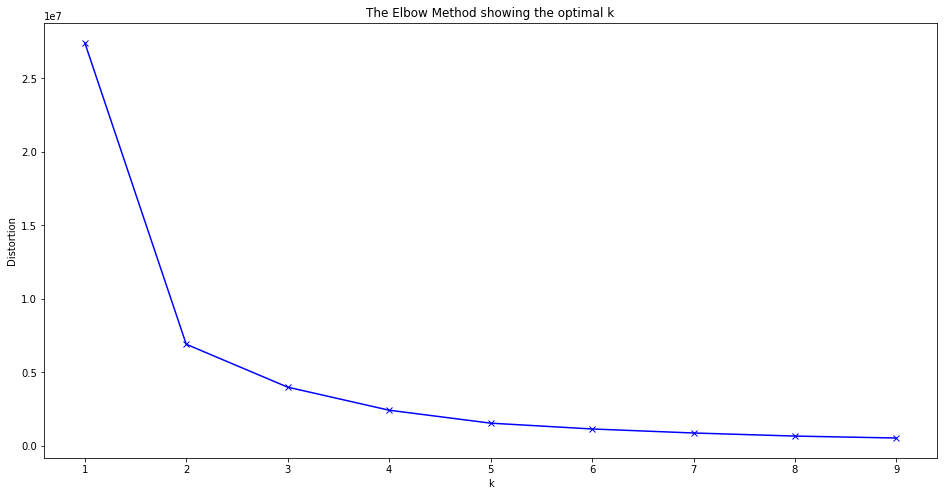

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From Elbow graph k=3 which is optimal for this case. Now we can run a K-Means using as n_clusters the number 3.

In [ ]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=3,featuresCol='features',seed=1)
from pyspark.ml import Pipeline
km_pipeline = Pipeline(stages=preprocessingStages+[kmeans])
km_pipeline_model = km_pipeline.fit(hackdf)

In [ ]:
km_pipeline_model.stages[-1]

KMeansModel: uid=KMeans_1c3dcfd4e193, k=3, distanceMeasure=euclidean, numFeatures=6

In [ ]:
Prediction = km_pipeline_model.transform(hackdf)

In [ ]:
Final_pred = Prediction.groupBy('prediction').count().show()      #The hackers doesn't have equal amount of attacks so we can say that 3rd hack was involved

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   83|
|         2|   84|
|         0|  167|
+----------+-----+



In [ ]:
kmeans_1 = KMeans(k=2,featuresCol='features',seed=1)
km_pipeline_1 = Pipeline(stages=preprocessingStages+[kmeans_1])
km_pip = km_pipeline_1.fit(hackdf)

In [ ]:
PRED = km_pip.transform(hackdf)

In [ ]:
PRED.groupBy("prediction").count().show()      #Now the hackers have equal amount of attacks

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [ ]:
prediction_1 = PRED.toPandas()

In [ ]:
prediction_1.to_csv("./Clustering_Project.csv")